In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/eos/home-d/dmapelli/public/latino/",
    "plot_config":     "Full2018v6s5",
    "cut":             "res_sig_mjjincl",
    "model_version":   "v68",
    #"model_tag":       "boost_5vars_v0",
    "samples_version": "v10",
    "cols": ['mjj_vbs',
             'vbs_0_pt',
             'vbs_1_pt', 
             'deltaeta_vbs',
             'Lepton_eta',
             'Zlep', 
             ]
# A_ww
}

In [3]:
len(config["cols"])

6

```.python
# config examples
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",
"model_tag":       "res_4depth_v0",
 ```

In [5]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [5]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

In [7]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values

Y_sig = np.ones(len(X_sig))

bkg.cat = bkg.sample_name
bkg.cat = []

enc = OneHotEncoder()

enc.fit(["Wjets", "top", "DY", "VBS", "VV"])


Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [9]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [11]:
# i = 2
# print(cols[i])
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
# ax1.hist(X[:,i], bins=50)
# ax1.set_yscale("log")
# ax2.hist(X_scaled[:,i], weights=W, bins=50)
# plt.yscale("log")

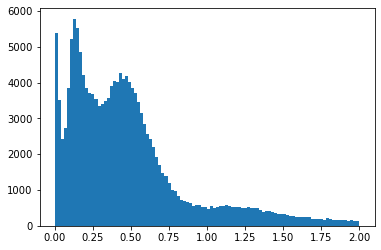

In [12]:
# _ = plt.hist(W, bins=100)
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [13]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [14]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (139993, 6)
Test + Val dataset:  (34999, 6)


Create generators to balance signal and background

In [15]:
config["batch_size"] = 2048

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
#validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test != val
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_temp,  y_temp,  W_temp,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test == val

## Keras model

In [16]:
%load_ext autoreload

In [17]:
%autoreload 2

In [18]:
# import local module that programmatically returns keras models
import dnn_models

model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.summary()

W0310 23:06:01.353649 139772135913280 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0310 23:06:01.388996 139772135913280 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0310 23:06:01.394811 139772135913280 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



>>> Creating model...


W0310 23:06:01.566759 139772135913280 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0310 23:06:01.606418 139772135913280 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0310 23:06:01.850431 139772135913280 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                350       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
__________

In [19]:
## import and configure the plot loss callback

import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_temp, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test != val
    "y_val" : y_temp, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_temp, ## test == val
    "Wnn_train": Wnn_train,
    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_temp, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, batch_mode=True)

In [20]:
## TRAINING

import time
start_time = time.time()

config["epochs"] = 30

history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[plot_losses],
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

Epoch 1/20
118/118 [==============================] - 2s 18ms/step - loss: 0.5765 - acc: 0.6316 - val_loss: 0.5497 - val_acc: 0.6413
Epoch 2/20
118/118 [==============================] - 1s 11ms/step - loss: 0.5547 - acc: 0.6429 - val_loss: 0.5479 - val_acc: 0.6438
Epoch 3/20
118/118 [==============================] - 1s 10ms/step - loss: 0.5508 - acc: 0.6469 - val_loss: 0.5444 - val_acc: 0.6456
Epoch 4/20
118/118 [==============================] - 1s 9ms/step - loss: 0.5490 - acc: 0.6487 - val_loss: 0.5433 - val_acc: 0.6464
Epoch 5/20
118/118 [==============================] - 1s 9ms/step - loss: 0.5485 - acc: 0.6508 - val_loss: 0.5428 - val_acc: 0.6483
Epoch 6/20
118/118 [==============================] - 1s 11ms/step - loss: 0.5472 - acc: 0.6517 - val_loss: 0.5428 - val_acc: 0.6484
Epoch 7/20
118/118 [==============================] - 1s 11ms/step - loss: 0.5467 - acc: 0.6519 - val_loss: 0.5441 - val_acc: 0.6489
Epoch 8/20
118/118 [==============================] - 1s 11ms/step - lo

<Figure size 432x288 with 0 Axes>

In [21]:
config["train_time"]

33.990073442459106

In [22]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [23]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")


W0310 23:06:43.475929 139772135913280 deprecation.py:323] From <ipython-input-23-39c8d219d3f3>:53: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0310 23:06:43.477826 139772135913280 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [24]:
## Retrieve graphs history
## plot 
# n = 30
# plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
# plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

### Columns List

```.python
# resolved
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

# boosted
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

         
# OLD
    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 'vbs_1_pt', 
             'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 'vjet_1_pt', 
             'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
```